In [ ]:
!pip install wfdb
!pip install hrv-analysis
!pip install py-ecg-detectors
!pip install neurokit2

from google.colab import output
output.clear()
print("All packages installed successfully!")

All packages installed successfully!


In [ ]:
import pprint
import os
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import wfdb
import hrvanalysis
import ecgdetectors
import hrv
import neurokit2 as nk

## BIDMC Congestive Heart Failure Database (CHFDB)

https://physionet.org/content/chfdb/1.0.0/

In [ ]:
# !wget -r -N -c -np https://physionet.org/files/chfdb/1.0.0/ -P "/content/drive/MyDrive/Projects/HRV/dataset"

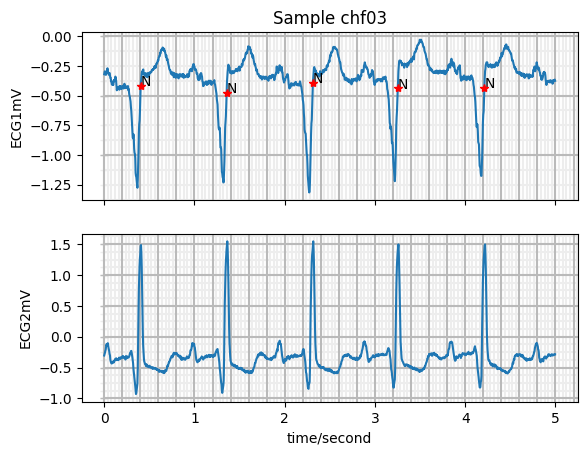

In [ ]:
CHFDB_DIR = "/content/drive/MyDrive/Projects/HRV/dataset/physionet.org/files/chfdb/1.0.0/"
record_samp = "chf03"
record = wfdb.rdrecord(os.path.join(CHFDB_DIR, record_samp), sampto=1250)
annotation = wfdb.rdann(os.path.join(CHFDB_DIR, record_samp), 'ecg', sampto=1250)
wfdb.plot_wfdb(
    record=record, annotation=annotation,
    title="Sample %s" % (record_samp),
    plot_sym=True,
    ecg_grids='all'
)
# pprint.pprint(record.__dict__)

In [ ]:
# record = wfdb.rdrecord(os.path.join(CHFDB_DIR, record_samp), sampto=1250)
# ann = wfdb.rdann(os.path.join(CHFDB_DIR, record_samp), 'ecg', sampto=1250)
# __sg = record.p_signal
# __ann = [ann.sample, ann.sample]
# wfdb.plot_items(
#     signal=__sg,
#     ann_samp=__ann,
#     title="Sample %s" % (record_samp),
#     time_units='seconds',
#     figsize=(10,4), ecg_grids='all', fs=250,
# )

In [ ]:
def slice_signal(record_obj, start_sec=0, end_sec=10, fs=250, _print=True, channel=0):
    start = fs*start_sec
    end = fs*end_sec
    signal = record_obj.p_signal[start:end, channel]

    if _print:
        print("start        :", start)
        print("end          :", end)
        print("end - start  :", end - start)
        print("len(signal)  :", len(signal))
        print("seconds      :", end_sec - start_sec)

    detectors = ecgdetectors.Detectors(fs)
    r_peaks = detectors.two_average_detector(signal)
    if _print:
        print("len(r_peaks) :", len(r_peaks))
    return signal, r_peaks

def plot_signal(signal: np.array, r_peaks: list=None, figsize=(6, 4)):
    fig = plt.figure(figsize=figsize)
    plt.plot(signal)
    plt.gca().set_xlabel("")
    plt.gca().set_ylabel("mV")

    # ref: https://stackoverflow.com/questions/24988448/how-to-draw-vertical-lines-on-a-given-plot
    if r_peaks:
        for xc in r_peaks:
            plt.axvline(x=xc, color='red', linestyle='--')

    plt.show()

In [ ]:
def segment(record_obj, start_sec=0, end_sec=20, size_sec=5, fs=250, _plot_signal=True, _print=True):
    short_term_signals = []
    short_term_r_peaks = []

    if end_sec == 'full':
        end_sec = len(record_obj.p_signal[:, 0]) // fs

    for _start_sec in range(start_sec, end_sec, size_sec):
        # get the signal slice and the corresponding r-peaks
        signal, r_peaks = slice_signal(
            record_obj,
            start_sec=_start_sec,
            end_sec=_start_sec+size_sec,
            fs=fs,
            _print=_print
        )
        # adjust the time points according to the frequency and the slice part
        r_peaks = list(np.array(r_peaks) + _start_sec*fs)
        # append the segmented signals and the corresponding r peaks
        short_term_r_peaks.append(r_peaks)
        short_term_signals.append(signal)

        if _plot_signal:
            plot_signal(signal, r_peaks)
        if _print:
            print(r_peaks)

    if _print:
        print("len(short_term_signals):", len(short_term_signals))
        print("len(short_term_r_peaks):", len(short_term_r_peaks))

    return short_term_signals, short_term_r_peaks

In [ ]:
from google.colab import output

DATABASE = "chfdb"
SAVE_DIR = "./dataset"
os.makedirs(os.path.join(SAVE_DIR, DATABASE), exist_ok=True)

start_time = datetime.datetime.now()

chfdb = {}

MENIT = 5
START_SEC = 0
END_SEC = "full"
SIZE_SEC = int(60 * MENIT)
FS = 250
_PLOT_SIGNAL = False
_PRINT = False
print("FS:", FS)
for record in wfdb.get_record_list(DATABASE):
    try:
        print("Record:", record)
        record_obj = wfdb.rdrecord(os.path.join(CHFDB_DIR, record))
        print("  signal length          :", record_obj.sig_len)
        print("  recording time (hours) :", record_obj.sig_len / (3600*FS))
        print("  comments               :", record_obj.comments)

        short_term_signals, short_term_r_peaks = segment(
            record_obj,
            start_sec=START_SEC,
            end_sec=END_SEC,
            size_sec=SIZE_SEC,
            fs=FS,
            _plot_signal=_PLOT_SIGNAL,
            _print=_PRINT
        )
        # for each corresponding signal and r-peaks
        for idx, (signal, r_peaks) in enumerate(zip(short_term_signals, short_term_r_peaks)):
            # retrieve rr_interval from distance between 2 r_peak points
            rri = [r_peaks[i+1] - r_peaks[i] for i in range(len(r_peaks) - 1)]
            # convert the unit from freq_sample to milisecond
            rri = list(np.array(rri) * 1000 / FS)
            print("  len(r_peaks)           :", len(r_peaks))
            print("  len(rri)               :", len(rri))
            print("  recording time (secs)  :", record_obj.sig_len / FS)
            print("  r_peak / seconds       :", len(r_peaks) / (record_obj.sig_len / FS))

            nni = hrvanalysis.get_nn_intervals(rri)
            print("  len(nni)               :", len(nni))
            time_domain = hrvanalysis.extract_features.get_time_domain_features(nni)
            print("  time_domain computed!")
            freq_domain = hrvanalysis.extract_features.get_frequency_domain_features(nni)
            print("  freq_domain computed!")
            geom = hrvanalysis.extract_features.get_geometrical_features(nni)
            print("  geometrical features computed!")
            poincare = hrvanalysis.extract_features.get_poincare_plot_features(nni)
            print("  poincare features computed!")
            csi_cvi = hrvanalysis.extract_features.get_csi_cvi_features(nni)
            print("  csi cvi computed!")
            # Function computing the sample entropy of the given data.
            # Must use this function on short term recordings, from 1 minute window.
            sampen = hrvanalysis.extract_features.get_sampen(nni)
            print("  sampen computed!")

            # save signal into parquet
            sig_array = np.array(signal, dtype=np.int32)
            filename = "{0}-{1}-{2}-{3}".format(DATABASE, record, SIZE_SEC*idx, SIZE_SEC*(1+idx))
            filepath = os.path.join(SAVE_DIR, DATABASE, str(filename)+".parquet")
            pd.DataFrame({"data": sig_array}).to_parquet(filepath)
            print("{0}.parquet saved!".format(filename))
            # signal saved!

            id = filename
            chfdb[id] = {
                "id": id,
                "start_secs": SIZE_SEC * idx,
                "end_secs": SIZE_SEC * (1+idx),
                "db_source": DATABASE,
                "age": record_obj.comments[0].split()[1],
                "gender": record_obj.comments[0].split()[3],
                "fs": FS,
                "signal_length": record_obj.sig_len,
                "recording_time_hours": record_obj.sig_len / (3600 * FS),
                "recording_time_seconds": record_obj.sig_len // FS,
                "rri_length": len(rri),
                "nni_length": len(nni),
                **time_domain,
                **freq_domain,
                **geom,
                **poincare,
                **csi_cvi,
                **sampen,
                "cardiac_info": " ".join(record_obj.comments[0].split()[4:7]),
                "risk": 1,
            }
            print("\nRECORD {} SAVED!\n".format(record))
            output.clear()
    except:
        print("\n ERROR (%s)\n" %record)

print("Running time:", datetime.datetime.now() - start_time)

Running time: 0:13:26.692214


In [ ]:
# pprint.pprint(chfdb)

In [ ]:
df_chfdb = pd.DataFrame(chfdb).T
df_chfdb

,id,start_secs,end_secs,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,...,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
chfdb-chf01-0-300,chfdb-chf01-0-300,0,300,chfdb,71,M,250,17994491,19.993879,71977,...,None,45.092711,65.54028,1.453456,1.453456,4.674735,381.039711,0.725348,NYHA class: III-IV,1
chfdb-chf01-300-600,chfdb-chf01-300-600,300,600,chfdb,71,M,250,17994491,19.993879,71977,...,None,20.973507,35.191381,1.677897,1.677897,4.072227,236.190021,1.082311,NYHA class: III-IV,1
chfdb-chf01-600-900,chfdb-chf01-600-900,600,900,chfdb,71,M,250,17994491,19.993879,71977,...,None,31.121189,50.592439,1.625659,1.625659,4.401262,328.984208,0.835905,NYHA class: III-IV,1
chfdb-chf01-900-1200,chfdb-chf01-900-1200,900,1200,chfdb,71,M,250,17994491,19.993879,71977,...,None,39.177884,53.728564,1.3714,1.3714,4.527366,294.733489,0.62327,NYHA class: III-IV,1
chfdb-chf01-1200-1500,chfdb-chf01-1200-1500,1200,1500,chfdb,71,M,250,17994491,19.993879,71977,...,None,40.288655,49.877567,1.238005,1.238005,4.507208,246.994759,0.724152,NYHA class: III-IV,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chfdb-chf15-70500-70800,chfdb-chf15-70500-70800,70500,70800,chfdb,53,M,250,17993443,19.992714,71973,...,None,22.544095,56.960446,2.526624,2.526624,4.312726,575.670446,0.456915,NYHA class: III-IV,1
chfdb-chf15-70800-71100,chfdb-chf15-70800-71100,70800,71100,chfdb,53,M,250,17993443,19.992714,71973,...,None,25.275594,60.619752,2.398351,2.398351,4.389436,581.549826,0.515533,NYHA class: III-IV,1
chfdb-chf15-71100-71400,chfdb-chf15-71100-71400,71100,71400,chfdb,53,M,250,17993443,19.992714,71973,...,None,27.601441,56.362782,2.042023,2.042023,4.396044,460.376429,0.501645,NYHA class: III-IV,1
chfdb-chf15-71400-71700,chfdb-chf15-71400-71700,71400,71700,chfdb,53,M,250,17993443,19.992714,71973,...,None,31.287242,81.569993,2.607133,2.607133,4.611018,850.655185,0.300619,NYHA class: III-IV,1


In [ ]:
df_chfdb.to_csv("df_chfdb_two_average.csv", index=False)
df_chfdb.to_excel("df_chfdb_two_average.xlsx", index=False)

In [ ]:
pd.read_csv("df_chfdb_two_average.csv")

,id,start_secs,end_secs,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,...,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
0,chfdb-chf01-0-300,0,300,chfdb,71,M,250,17994491,19.993879,71977,...,NaN,45.092711,65.540280,1.453456,1.453456,4.674735,381.039711,0.725348,NYHA class: III-IV,1
1,chfdb-chf01-300-600,300,600,chfdb,71,M,250,17994491,19.993879,71977,...,NaN,20.973507,35.191381,1.677897,1.677897,4.072227,236.190021,1.082311,NYHA class: III-IV,1
2,chfdb-chf01-600-900,600,900,chfdb,71,M,250,17994491,19.993879,71977,...,NaN,31.121189,50.592439,1.625659,1.625659,4.401262,328.984208,0.835905,NYHA class: III-IV,1
3,chfdb-chf01-900-1200,900,1200,chfdb,71,M,250,17994491,19.993879,71977,...,NaN,39.177884,53.728564,1.371400,1.371400,4.527366,294.733489,0.623270,NYHA class: III-IV,1
4,chfdb-chf01-1200-1500,1200,1500,chfdb,71,M,250,17994491,19.993879,71977,...,NaN,40.288655,49.877567,1.238005,1.238005,4.507208,246.994759,0.724152,NYHA class: III-IV,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3585,chfdb-chf15-70500-70800,70500,70800,chfdb,53,M,250,17993443,19.992714,71973,...,NaN,22.544095,56.960446,2.526624,2.526624,4.312726,575.670446,0.456915,NYHA class: III-IV,1
3586,chfdb-chf15-70800-71100,70800,71100,chfdb,53,M,250,17993443,19.992714,71973,...,NaN,25.275594,60.619752,2.398351,2.398351,4.389436,581.549826,0.515533,NYHA class: III-IV,1
3587,chfdb-chf15-71100-71400,71100,71400,chfdb,53,M,250,17993443,19.992714,71973,...,NaN,27.601441,56.362782,2.042023,2.042023,4.396044,460.376429,0.501645,NYHA class: III-IV,1
3588,chfdb-chf15-71400-71700,71400,71700,chfdb,53,M,250,17993443,19.992714,71973,...,NaN,31.287242,81.569993,2.607133,2.607133,4.611018,850.655185,0.300619,NYHA class: III-IV,1


In [ ]:
pd.read_excel("df_chfdb_two_average.xlsx")

,id,start_secs,end_secs,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,...,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
0,chfdb-chf01-0-240,0,240,chfdb,71,M,250,17994491,19.993879,71977,...,NaN,48.932453,69.043998,1.411006,1.411006,4.732843,389.686061,0.734728,NYHA class: III-IV,1
1,chfdb-chf01-240-480,240,480,chfdb,71,M,250,17994491,19.993879,71977,...,NaN,21.431502,37.355300,1.743009,1.743009,4.107525,260.442485,1.000695,NYHA class: III-IV,1
2,chfdb-chf01-480-720,480,720,chfdb,71,M,250,17994491,19.993879,71977,...,NaN,23.335926,44.023719,1.886521,1.886521,4.215832,332.206714,1.200227,NYHA class: III-IV,1
3,chfdb-chf01-720-960,720,960,chfdb,71,M,250,17994491,19.993879,71977,...,NaN,30.703005,58.587961,1.908216,1.908216,4.459109,447.193907,0.718536,NYHA class: III-IV,1
4,chfdb-chf01-960-1200,960,1200,chfdb,71,M,250,17994491,19.993879,71977,...,NaN,43.757057,54.161363,1.237774,1.237774,4.578858,268.158184,0.586175,NYHA class: III-IV,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4481,chfdb-chf15-70800-71040,70800,71040,chfdb,53,M,250,17993443,19.992714,71973,...,NaN,25.684918,62.427422,2.430509,2.430509,4.409174,606.921624,0.519150,NYHA class: III-IV,1
4482,chfdb-chf15-71040-71280,71040,71280,chfdb,53,M,250,17993443,19.992714,71973,...,NaN,24.487074,50.332105,2.055456,2.055456,4.294902,413.821715,0.880435,NYHA class: III-IV,1
4483,chfdb-chf15-71280-71520,71280,71520,chfdb,53,M,250,17993443,19.992714,71973,...,NaN,25.442155,55.908894,2.197490,2.197490,4.357155,491.437051,0.503620,NYHA class: III-IV,1
4484,chfdb-chf15-71520-71760,71520,71760,chfdb,53,M,250,17993443,19.992714,71973,...,NaN,35.831369,100.036584,2.791872,2.791872,4.758542,1117.157218,0.292482,NYHA class: III-IV,1


## Uses Defined Annotations

In [ ]:
from google.colab import output

DATABASE = "chfdb"

start_time = datetime.datetime.now()

FS = 250

MENIT = 5
SIZE_SEC = int(60 * MENIT)
WINDOW_SIZE = SIZE_SEC * FS

END_SEC = int(60 * 120) * FS
# END_SEC = max(r_peaks)

# OVERLAP means percentage of overlap, values between [0, 1)
OVERLAP = 0.5

chfdb = {}
errs = []
for record in wfdb.get_record_list(DATABASE):
    ann = wfdb.rdann(os.path.join(CHFDB_DIR, record), extension='ecg')
    record_hea = wfdb.rdheader(os.path.join(CHFDB_DIR, record))
    record_obj = wfdb.rdrecord(os.path.join(CHFDB_DIR, record))

    r_peaks = np.array(ann.sample, dtype=np.float32)
    annotation = np.array(ann.symbol)

    start_sec = 0
    while start_sec < END_SEC:
        output.clear()
        end_sec = start_sec + WINDOW_SIZE

        print("New Record           :", record)
        print("  Start Sec          : %d" % int(start_sec//FS))
        print("  End Sec            : %d" % int(end_sec//FS))

        cond = (start_sec <= r_peaks) & (r_peaks < end_sec)
        _r_peak = r_peaks[cond]
        _annotation = annotation[cond]

        # counting ectopic beats
        abnormal_beat_num = 0
        for _sym, _count in np.transpose(np.unique(_annotation, return_counts=True)):
            if _sym != 'N':
                abnormal_beat_num += int(_count)
            if _sym == 'N':
                normal_beat_num = int(_count)
        normal_beats_ratio = normal_beat_num / (normal_beat_num + abnormal_beat_num)

        # check & replace ectopic beat with np.nan
        for idx, ann in enumerate(_annotation):
            if str(ann).upper() != 'N':
                _r_peak[idx] = np.nan
        # interpolate
        _r_peak = hrvanalysis.preprocessing.interpolate_nan_values(_r_peak)

        # retrieve rr_interval from distance between 2 r_peak points
        rri = [_r_peak[i+1] - _r_peak[i] for i in range(len(_r_peak) - 1)]
        # convert the unit from freq_sample to milisecond
        rri = list(np.array(rri) * 1000 / FS)
        print("  len(_r_peak)           :", len(_r_peak))
        print("  len(rri)               :", len(rri))

        id = "{0}-{1}-{2}-{3}".format(DATABASE, record, start_sec//FS, end_sec//FS)
        try:
            rri = hrvanalysis.preprocessing.remove_outliers(
                rri,
                low_rri = 300,
                high_rri = 2000,
            )
            nni = hrvanalysis.preprocessing.interpolate_nan_values(rri)

            # remove nan values if exists
            nni = [val for val in nni if np.isfinite(val)]
            print("  len(nni)               :", len(nni))
            time_domain = hrvanalysis.extract_features.get_time_domain_features(nni)
            print("  time_domain computed!")
            freq_domain = hrvanalysis.extract_features.get_frequency_domain_features(nni)
            print("  freq_domain computed!")
            geom = hrvanalysis.extract_features.get_geometrical_features(nni)
            print("  geometrical features computed!")
            poincare = hrvanalysis.extract_features.get_poincare_plot_features(nni)
            print("  poincare features computed!")
            csi_cvi = hrvanalysis.extract_features.get_csi_cvi_features(nni)
            print("  csi cvi computed!")
            # Function computing the sample entropy of the given data.
            # Must use this function on short term recordings, from 1 minute window.
            sampen = hrvanalysis.extract_features.get_sampen(nni)
            print("  sampen computed!")

            chfdb[id] = {
                "id": id,
                "start_secs": start_sec // FS,
                "end_secs": end_sec // FS,
                "db_source": DATABASE,
                "age": record_hea.comments[0].split()[1],
                "gender": record_hea.comments[0].split()[3],
                "fs": FS,
                "signal_length": record_obj.sig_len,
                "recording_time_hours": record_obj.sig_len / (3600 * FS),
                "recording_time_seconds": record_obj.sig_len // FS,
                "normal_beats": normal_beat_num,
                "abnormal_beats": abnormal_beat_num,
                "normal_beats_ratio": normal_beats_ratio,
                "rri_length": len(rri),
                "nni_length": len(nni),
                **time_domain,
                **freq_domain,
                **geom,
                **poincare,
                **csi_cvi,
                **sampen,
                "cardiac_info": " ".join(record_obj.comments[0].split()[4:7]),
                "risk": 1,
            }
            print("  RECORD {} SAVED!\n".format(id))
        except:
            print("  \nERROR at {}\n".format(id))
            errs.append(id)
        finally:
            start_sec = start_sec + int(WINDOW_SIZE * (1 - OVERLAP))

print("\n"+"="*50)
print(datetime.datetime.now() - start_time)
print("error nums   :", len(errs))

New Record           : chf15
  Start Sec          : 7050
  End Sec            : 7350
  len(_r_peak)           : 520
  len(rri)               : 519
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [nan]
  len(nni)               : 518
  time_domain computed!
  freq_domain computed!
  geometrical features computed!
  poincare features computed!
  csi cvi computed!
  sampen computed!
  RECORD chfdb-chf15-7050-7350 SAVED!


0:02:23.486526
error nums   : 0


In [ ]:
df_chfdb = pd.DataFrame(chfdb).T
df_chfdb

,id,start_secs,end_secs,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,normal_beats,abnormal_beats,normal_beats_ratio,rri_length,nni_length,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,triangular_index,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
chfdb-chf01-0-300,chfdb-chf01-0-300,0,300,chfdb,71,M,250,17994491,19.993879,71977,332,1,0.996997,332,332,901.686747,32.541464,14.610487,1,0.302115,44,13.293051,14.616962,904.0,204.0,0.016211,0.03609,66.628311,76.530612,60.728745,2.400039,42.99273,28.779617,1.49386,59.901524,40.098476,406.664613,334.892266,6.036364,None,10.346816,44.842359,4.333928,4.333928,3.870615,777.374311,1.270644,NYHA class: III-IV,1
chfdb-chf01-150-450,chfdb-chf01-150-450,150,450,chfdb,71,M,250,17994491,19.993879,71977,329,1,0.99697,329,329,909.617021,24.169356,12.77043,0,0.0,31,9.45122,12.77192,908.0,140.0,0.014041,0.026571,66.008669,72.115385,61.728395,1.767333,17.538572,26.712807,0.65656,39.633956,60.366044,200.899636,156.648256,4.445946,None,9.043854,32.962467,3.644737,3.644737,3.678493,480.558028,1.115368,NYHA class: III-IV,1
chfdb-chf01-300-600,chfdb-chf01-300-600,300,600,chfdb,71,M,250,17994491,19.993879,71977,326,0,1.0,325,325,920.738462,24.224182,12.868557,0,0.0,29,8.950617,12.869718,920.0,124.0,0.013978,0.02631,65.20976,69.444444,60.728745,1.701655,33.582199,25.675798,1.307932,56.671168,43.328832,279.049296,219.7913,6.914894,None,9.113519,33.023716,3.623597,3.623597,3.682632,478.658501,1.262104,NYHA class: III-IV,1
chfdb-chf01-450-750,chfdb-chf01-450-750,450,750,chfdb,71,M,250,17994491,19.993879,71977,315,0,1.0,314,314,952.038217,33.775785,14.570035,0,0.0,38,12.140575,14.57031,952.0,152.0,0.015304,0.035477,63.102214,68.493151,58.365759,2.246867,26.634051,34.32667,0.7759,43.690512,56.309488,228.747777,167.787056,8.486486,None,10.319068,46.638226,4.519616,4.519616,3.886502,843.147508,1.366189,NYHA class: III-IV,1
chfdb-chf01-600-900,chfdb-chf01-600-900,600,900,chfdb,71,M,250,17994491,19.993879,71977,304,1,0.996721,304,304,983.381579,21.267721,16.854958,0,0.0,55,18.151815,16.855041,984.0,128.0,0.01714,0.021627,61.042722,65.502183,57.471264,1.332902,25.122541,44.469915,0.564933,36.099518,63.900482,308.753581,239.161126,6.333333,None,11.937971,27.606462,2.312492,2.312492,3.722061,255.358889,1.461932,NYHA class: III-IV,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chfdb-chf15-6450-6750,chfdb-chf15-6450-6750,6450,6750,chfdb,53,M,250,17993443,19.992714,71973,470,6,0.987395,475,475,630.922105,40.410346,7.266318,0,0.0,1,0.21097,7.26938,640.0,148.0,0.011522,0.06405,95.494348,107.913669,85.227273,6.189308,52.954578,8.487056,6.239452,86.1868,13.8132,448.851484,387.409851,12.179487,None,5.143491,56.916927,11.065816,11.065816,3.670619,2519.329025,0.383245,NYHA class: III-IV,1
chfdb-chf15-6600-6900,chfdb-chf15-6600-6900,6600,6900,chfdb,53,M,250,17993443,19.992714,71973,513,6,0.988439,518,518,578.0,36.709535,7.088939,0,0.0,1,0.193424,7.090463,564.0,184.0,0.012267,0.063511,104.196554,117.1875,86.206897,6.16936,10.453498,6.641627,1.573936,61.149,38.851,109.140167,92.045042,5.029126,None,5.017491,51.672088,10.298391,10.298391,3.617863,2128.557405,0.616521,NYHA class: III-IV,1
chfdb-chf15-6750-7050,chfdb-chf15-6750-7050,6750,7050,chfdb,53,M,250,17993443,19.992714,71973,527,7,0.986891,533,533,561.966229,14.080555,7.549336,0,0.0,0,0.0,7.549336,564.0,84.0,0.013434,0.025056,106.835813,117.1875,100.671141,2.712032,8.418311,4.993244,1.68594,62.76909,37.23091,70.243348,56.831793,3.977612,None,5.343211,19.182652,3.590098,3.590098,3.214831,275.470395,1.698874,NYHA class: III-IV,1
chfdb-chf15-6900-7200,chfdb-chf15-6900-7200,6900,7200,chfdb,53,M,250,17993443,19.992714,71973,509,12,0.976967,520,520,576.1230

In [ ]:
df_chfdb.to_csv("df_chfdb.csv", index=False)
df_chfdb.to_excel("df_chfdb.xlsx", index=False)

In [ ]:
pd.set_option("display.max_columns", None)

In [ ]:
pd.read_csv("df_chfdb.csv")

,id,start_secs,end_secs,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,normal_beats,abnormal_beats,normal_beats_ratio,rri_length,nni_length,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,triangular_index,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
0,chfdb-chf01-0-300,0,300,chfdb,71,M,250,17994491,19.993879,71977,332,1,0.996997,332,332,901.686747,32.541464,14.610487,1,0.302115,44,13.293051,14.616962,904.0,204.0,0.016211,0.036090,66.628311,76.530612,60.728745,2.400039,42.992730,28.779617,1.493860,59.901524,40.098476,406.664613,334.892266,6.036364,NaN,10.346816,44.842359,4.333928,4.333928,3.870615,777.374311,1.270644,NYHA class: III-IV,1
1,chfdb-chf01-150-450,150,450,chfdb,71,M,250,17994491,19.993879,71977,329,1,0.996970,329,329,909.617021,24.169356,12.770430,0,0.000000,31,9.451220,12.771920,908.0,140.0,0.014041,0.026571,66.008669,72.115385,61.728395,1.767333,17.538572,26.712807,0.656560,39.633956,60.366044,200.899636,156.648256,4.445946,NaN,9.043854,32.962467,3.644737,3.644737,3.678493,480.558028,1.115368,NYHA class: III-IV,1
2,chfdb-chf01-300-600,300,600,chfdb,71,M,250,17994491,19.993879,71977,326,0,1.000000,325,325,920.738462,24.224182,12.868557,0,0.000000,29,8.950617,12.869718,920.0,124.0,0.013978,0.026310,65.209760,69.444444,60.728745,1.701655,33.582199,25.675798,1.307932,56.671168,43.328832,279.049296,219.791300,6.914894,NaN,9.113519,33.023716,3.623597,3.623597,3.682632,478.658501,1.262104,NYHA class: III-IV,1
3,chfdb-chf01-450-750,450,750,chfdb,71,M,250,17994491,19.993879,71977,315,0,1.000000,314,314,952.038217,33.775785,14.570035,0,0.000000,38,12.140575,14.570310,952.0,152.0,0.015304,0.035477,63.102214,68.493151,58.365759,2.246867,26.634051,34.326670,0.775900,43.690512,56.309488,228.747777,167.787056,8.486486,NaN,10.319068,46.638226,4.519616,4.519616,3.886502,843.147508,1.366189,NYHA class: III-IV,1
4,chfdb-chf01-600-900,600,900,chfdb,71,M,250,17994491,19.993879,71977,304,1,0.996721,304,304,983.381579,21.267721,16.854958,0,0.000000,55,18.151815,16.855041,984.0,128.0,0.017140,0.021627,61.042722,65.502183,57.471264,1.332902,25.122541,44.469915,0.564933,36.099518,63.900482,308.753581,239.161126,6.333333,NaN,11.937971,27.606462,2.312492,2.312492,3.722061,255.358889,1.461932,NYHA class: III-IV,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,chfdb-chf15-6450-6750,6450,6750,chfdb,53,M,250,17993443,19.992714,71973,470,6,0.987395,475,475,630.922105,40.410346,7.266318,0,0.000000,1,0.210970,7.269380,640.0,148.0,0.011522,0.064050,95.494348,107.913669,85.227273,6.189308,52.954578,8.487056,6.239452,86.186800,13.813200,448.851484,387.409851,12.179487,NaN,5.143491,56.916927,11.065816,11.065816,3.670619,2519.329025,0.383245,NYHA class: III-IV,1
716,chfdb-chf15-6600-6900,6600,6900,chfdb,53,M,250,17993443,19.992714,71973,513,6,0.988439,518,518,578.000000,36.709535,7.088939,0,0.000000,1,0.193424,7.090463,564.0,184.0,0.012267,0.063511,104.196554,117.187500,86.206897,6.169360,10.453498,6.641627,1.573936,61.149000,38.851000,109.140167,92.045042,5.029126,NaN,5.017491,51.672088,10.298391,10.298391,3.617863,2128.557405,0.616521,NYHA class: III-IV,1
717,chfdb-chf15-6750-7050,6750,7050,chfdb,53,M,250,17993443,19.992714,71973,527,7,0.986891,533,533,561.966229,14.080555,7.549336,0,0.000000,0,0.000000,7.549336,564.0,84.0,0.013434,0.025056,106.835813,117.187500,100.671141,2.712032,8.418311,4.993244,1.685940,62.769090,37.230910,70.243348,56.831793,3.977612,NaN,5.343211,19.182652,3.590098,3.590098,3.214831,275.470395,1.698874,NYHA class: III-IV,1
718,chfdb-chf15-6900-7200,6900,7200,chfdb,53,M,250,17993443,19.992714,71973,509,12,0.976967,520,520,576.123077,12.003221,8.658794,0,0.000000,5,0.963391,8.658808,576.0,80.0,0.015029,0.

In [ ]:
# df_chfdb.query("id == 'chfdb-chf08-6150-6450'")

In [ ]:
pd.read_excel("df_chfdb.xlsx")

,id,start_secs,end_secs,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,normal_beats,abnormal_beats,normal_beats_ratio,rri_length,nni_length,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,triangular_index,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
0,chfdb-chf01-0-300,0,300,chfdb,71,M,250,17994491,19.993879,71977,332,1,0.996997,332,332,901.686747,32.541464,14.610487,1,0.302115,44,13.293051,14.616962,904.0,204.0,0.016211,0.036090,66.628311,76.530612,60.728745,2.400039,42.992730,28.779617,1.493860,59.901524,40.098476,406.664613,334.892266,6.036364,NaN,10.346816,44.842359,4.333928,4.333928,3.870615,777.374311,1.270644,NYHA class: III-IV,1
1,chfdb-chf01-150-450,150,450,chfdb,71,M,250,17994491,19.993879,71977,329,1,0.996970,329,329,909.617021,24.169356,12.770430,0,0.000000,31,9.451220,12.771920,908.0,140.0,0.014041,0.026571,66.008669,72.115385,61.728395,1.767333,17.538572,26.712807,0.656560,39.633956,60.366044,200.899636,156.648256,4.445946,NaN,9.043854,32.962467,3.644737,3.644737,3.678493,480.558028,1.115368,NYHA class: III-IV,1
2,chfdb-chf01-300-600,300,600,chfdb,71,M,250,17994491,19.993879,71977,326,0,1.000000,325,325,920.738462,24.224182,12.868557,0,0.000000,29,8.950617,12.869718,920.0,124.0,0.013978,0.026310,65.209760,69.444444,60.728745,1.701655,33.582199,25.675798,1.307932,56.671168,43.328832,279.049296,219.791300,6.914894,NaN,9.113519,33.023716,3.623597,3.623597,3.682632,478.658501,1.262104,NYHA class: III-IV,1
3,chfdb-chf01-450-750,450,750,chfdb,71,M,250,17994491,19.993879,71977,315,0,1.000000,314,314,952.038217,33.775785,14.570035,0,0.000000,38,12.140575,14.570310,952.0,152.0,0.015304,0.035477,63.102214,68.493151,58.365759,2.246867,26.634051,34.326670,0.775900,43.690512,56.309488,228.747777,167.787056,8.486486,NaN,10.319068,46.638226,4.519616,4.519616,3.886502,843.147508,1.366189,NYHA class: III-IV,1
4,chfdb-chf01-600-900,600,900,chfdb,71,M,250,17994491,19.993879,71977,304,1,0.996721,304,304,983.381579,21.267721,16.854958,0,0.000000,55,18.151815,16.855041,984.0,128.0,0.017140,0.021627,61.042722,65.502183,57.471264,1.332902,25.122541,44.469915,0.564933,36.099518,63.900482,308.753581,239.161126,6.333333,NaN,11.937971,27.606462,2.312492,2.312492,3.722061,255.358889,1.461932,NYHA class: III-IV,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,chfdb-chf15-6450-6750,6450,6750,chfdb,53,M,250,17993443,19.992714,71973,470,6,0.987395,475,475,630.922105,40.410346,7.266318,0,0.000000,1,0.210970,7.269380,640.0,148.0,0.011522,0.064050,95.494348,107.913669,85.227273,6.189308,52.954578,8.487056,6.239452,86.186800,13.813200,448.851484,387.409851,12.179487,NaN,5.143491,56.916927,11.065816,11.065816,3.670619,2519.329025,0.383245,NYHA class: III-IV,1
716,chfdb-chf15-6600-6900,6600,6900,chfdb,53,M,250,17993443,19.992714,71973,513,6,0.988439,518,518,578.000000,36.709535,7.088939,0,0.000000,1,0.193424,7.090463,564.0,184.0,0.012267,0.063511,104.196554,117.187500,86.206897,6.169360,10.453498,6.641627,1.573936,61.149000,38.851000,109.140167,92.045042,5.029126,NaN,5.017491,51.672088,10.298391,10.298391,3.617863,2128.557405,0.616521,NYHA class: III-IV,1
717,chfdb-chf15-6750-7050,6750,7050,chfdb,53,M,250,17993443,19.992714,71973,527,7,0.986891,533,533,561.966229,14.080555,7.549336,0,0.000000,0,0.000000,7.549336,564.0,84.0,0.013434,0.025056,106.835813,117.187500,100.671141,2.712032,8.418311,4.993244,1.685940,62.769090,37.230910,70.243348,56.831793,3.977612,NaN,5.343211,19.182652,3.590098,3.590098,3.214831,275.470395,1.698874,NYHA class: III-IV,1
718,chfdb-chf15-6900-7200,6900,7200,chfdb,53,M,250,17993443,19.992714,71973,509,12,0.976967,520,520,576.123077,12.003221,8.658794,0,0.000000,5,0.963391,8.658808,576.0,80.0,0.015029,0.

### Checking Annotations

In [ ]:
FS = 250

In [ ]:
print(wfdb.get_record_list("chfdb"))

['chf01', 'chf02', 'chf03', 'chf04', 'chf05', 'chf06', 'chf07', 'chf08', 'chf09', 'chf10', 'chf11', 'chf12', 'chf13', 'chf14', 'chf15']


In [ ]:
record = "chf01"
rec_ann = wfdb.rdann(os.path.join(CHFDB_DIR, record), extension='ecg')
rec_obj = wfdb.rdrecord(os.path.join(CHFDB_DIR, record))

In [ ]:
anns = rec_ann.sample
anns[:100]

array([   28,   224,   438,   653,   868,  1081,  1296,  1512,  1726,
        1942,  2159,  2374,  2590,  2804,  3017,  3229,  3441,  3655,
        3865,  4080,  4292,  4504,  4718,  4931,  5147,  5359,  5571,
        5786,  6000,  6216,  6423,  6640,  6856,  7070,  7285,  7499,
        7716,  7935,  8153,  8370,  8586,  8800,  9012,  9230,  9449,
        9665,  9882, 10104, 10323, 10542, 10762, 10982, 11202, 11424,
       11644, 11865, 12089, 12312, 12539, 12765, 12990, 13208, 13434,
       13665, 13896, 14129, 14357, 14587, 14822, 15048, 15275, 15505,
       15737, 15965, 16192, 16421, 16649, 16880, 17111, 17340, 17566,
       17797, 18029, 18265, 18500, 18736, 18975, 19220, 19461, 19702,
       19943, 20188, 20435, 20676, 20919, 21160, 21405, 21649, 21894,
       22135])

In [ ]:
def plot_signal(signal: np.array, r_peaks: list=None, figsize=(6, 4), title=None):
    fig = plt.figure(figsize=figsize)
    plt.plot(signal)
    plt.gca().set_xlabel("")
    plt.gca().set_ylabel("mV")
    if title:
        plt.title(str(title))

    # ref: https://stackoverflow.com/questions/24988448/how-to-draw-vertical-lines-on-a-given-plot
    if r_peaks:
        for xc in r_peaks:
            if xc <= len(signal):
                plt.axvline(x=xc, color='red', linestyle='--')

    plt.xlabel("time point")
    plt.show()

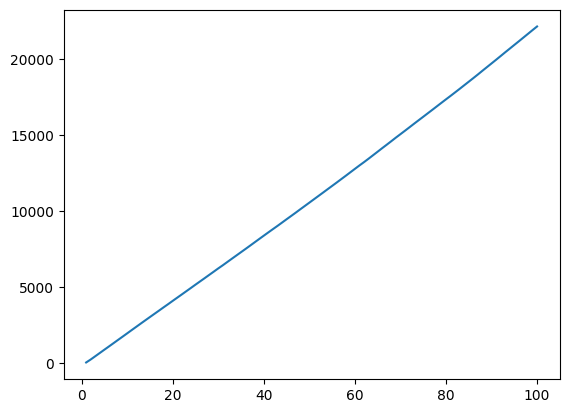

In [ ]:
ann_to_plot = anns[:100]
xs = [i+1 for i in range(len(ann_to_plot))]
plt.plot(xs, ann_to_plot)
plt.show()

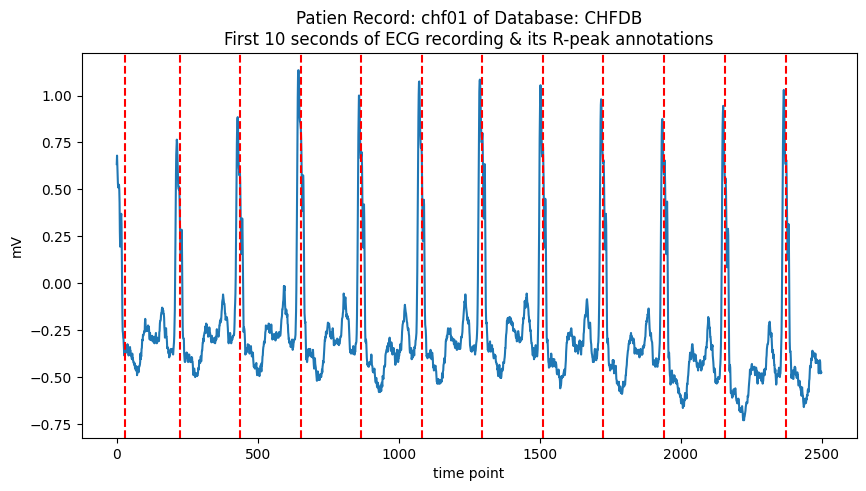

In [ ]:
SECONDS = 10
title = "Patien Record: {0} of Database: CHFDB\nFirst {1} seconds of ECG recording & its R-peak annotations".format(record, SECONDS)
plot_signal(
    rec_obj.p_signal[:FS*SECONDS, 0],
    r_peaks=list(anns[:500]),
    title=title,
    figsize=(10, 5)
)

## Plot RRI

In [ ]:
from google.colab import output

DATABASE = "chfdb"

start_time = datetime.datetime.now()

FS = 250

MENIT = 5
SIZE_SEC = int(60 * MENIT)
WINDOW_SIZE = SIZE_SEC * FS

END_SEC = int(60 * 120) * FS
# END_SEC = max(r_peaks)

# OVERLAP means percentage of overlap, values between [0, 1)
OVERLAP = 0.5

chfdb = {}
errs = []
for record in wfdb.get_record_list(DATABASE):
    ann = wfdb.rdann(os.path.join(CHFDB_DIR, record), extension='ecg')
    record_hea = wfdb.rdheader(os.path.join(CHFDB_DIR, record))
    record_obj = wfdb.rdrecord(os.path.join(CHFDB_DIR, record))

    r_peaks = np.array(ann.sample, dtype=np.float32)
    annotation = np.array(ann.symbol)

    start_sec = 0
    while start_sec < END_SEC:
        output.clear()
        end_sec = start_sec + WINDOW_SIZE

        print("New Record           :", record)
        print("  Start Sec          : %d" % int(start_sec//FS))
        print("  End Sec            : %d" % int(end_sec//FS))

        cond = (start_sec <= r_peaks) & (r_peaks < end_sec)
        _r_peak = r_peaks[cond]
        _annotation = annotation[cond]

        # check & replace ectopic beat with np.nan
        for idx, ann in enumerate(_annotation):
            if str(ann).upper() != 'N':
                _r_peak[idx] = np.nan
        # interpolate
        _r_peak = hrvanalysis.preprocessing.interpolate_nan_values(_r_peak)

        # retrieve rr_interval from distance between 2 r_peak points
        rri = [_r_peak[i+1] - _r_peak[i] for i in range(len(_r_peak) - 1)]
        # convert the unit from freq_sample to milisecond
        rri = list(np.array(rri) * 1000 / FS)
        print("  len(_r_peak)           :", len(_r_peak))
        print("  len(rri)               :", len(rri))

        id = "{0}-{1}-{2}-{3}".format(DATABASE, record, start_sec//FS, end_sec//FS)
        break
    break